In [ ]:
# Optimisation Algorithms in Non-Convex Classification Problems with Adversarial Training

In [ ]:
# MINI-BATCH GRADIENT

In [ ]:
# Import data from MNIST

In [3]:
import torch
use_cuda = False # GPU seems to raise erros on my side
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
from data_utils import get_mnist, build_data_loaders
train_dataset, test_dataset = get_mnist(normalize=True)
train_dataset.data.mean(0).mean().item(), test_dataset.data.mean(0).mean().item()

(-7.328089801639237e-10, 0.002495675580576062)

In [ ]:

# Values should be (-7.328089801639237e-10, 0.002495675580576062) if the import was successful

In [ ]:
# Tuning Hyperparameters for Minibatch to ensure equitable comparision to the other algorithms tested
# Use the Ray Tune library to run Bayes Search on the following parameters:
# The learning rate
# The batch size
# Whether we have a decreasing learning rate or not

In [4]:
from ray import tune
from net import Net
import numpy as np 
import pandas
from minibatch import minibatch_run, minibatch_tune

In [5]:
from ray.tune.suggest.bayesopt import BayesOptSearch
space = {
            "lr": tune.uniform(1e-4, 1e-2),
            "b_size": tune.uniform(2, 128),
            "dec_lr": tune.uniform(0, 1)
        }
samples = 1 # Suggested value by the Ray Tune Docs

In [ ]:
# Note here that the neural net deployed here is found in the net.py file
# The Loss function throughout is simply Torch's CrossEntropyLoss
# Bayes Search here focuses on maximising the average accuracy (out of 100%)

In [6]:
tune_net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
bayesopt = BayesOptSearch(metric="mean_accuracy", mode="max")

In [ ]:
# The tuning function is found in the minibatch.py file and based on the standard format for Ray Tune calls
# It stores the result of the 10 runs in a pandas dataframe and then returns the highest average accuracy and the associated parameters

In [ ]:
best_config, best_result = minibatch_tune(tune_net, train_dataset, test_dataset, samples, criterion, space, bayesopt, device)

In [ ]:
best_config

In [7]:
epochs = 10
batch_size = 91
learning_rate = 0.01
decreasing_lr = False

In [ ]:
epochs = 10
batch_size = int(best_config["b_size"])
learning_rate = best_config["lr"]
decreasing_lr = best_config["dec_lr"]

In [ ]:
if decreasing_lr < 0.5:
    print("Best Result was {:.2f}% with a Batch Size of {} and a fixed learning rate of {:.4f}".format(best_result*100, batch_size, learning_rate))
else:
    print("Best Result was {:.2f}% with a Batch Size of {} and a learning rate of {:.4f} that was decreasing".format(best_result*100, batch_size, learning_rate))

In [ ]:
# Training and Testing under Normal Conditions

In [33]:
net_naive = Net().to(device)
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
for x, y in train_loader:
    print(x.shape, y.shape)
    print(train_loader)
    break

torch.Size([91, 1, 1, 1, 1, 1, 1, 28, 28]) torch.Size([91])


In [ ]:
### Test the setup with the Minibatch Optimiser from the minibatch.py file
### Accuracy here is the percentage of correctly guessed labels

In [9]:
from training import training, testing, accuracy
from minibatch import MiniBatchOptimizer

mini_opt = MiniBatchOptimizer(net_naive.parameters(), lr=learning_rate, decreasing_lr=decreasing_lr)

In [10]:
import matplotlib.pyplot as plt

In [11]:
losses, acc = training(net_naive, train_loader, mini_opt, criterion, accuracy, epochs=epochs, device=device)

Launching training on cpu
batch 100	loss = 2.041	acc = 0.6813
batch 200	loss = 0.6959	acc = 0.9011
batch 300	loss = 0.5407	acc = 0.8462
batch 400	loss = 0.2347	acc = 0.9231
batch 500	loss = 0.4743	acc = 0.8681
batch 600	loss = 0.2717	acc = 0.9121
epoch 0	avg epoch loss = 0.819	avg epoch acc = 0.7957
batch 100	loss = 0.1567	acc = 0.978
batch 200	loss = 0.1069	acc = 0.967
batch 300	loss = 0.2364	acc = 0.9231
batch 400	loss = 0.1269	acc = 0.956
batch 500	loss = 0.2503	acc = 0.9231
batch 600	loss = 0.1206	acc = 0.967
epoch 1	avg epoch loss = 0.1867	avg epoch acc = 0.9452
batch 100	loss = 0.1096	acc = 0.989
batch 200	loss = 0.07009	acc = 0.967
batch 300	loss = 0.1518	acc = 0.956
batch 400	loss = 0.09254	acc = 0.978
batch 500	loss = 0.1558	acc = 0.956
batch 600	loss = 0.08683	acc = 0.978
epoch 2	avg epoch loss = 0.1264	avg epoch acc = 0.963
batch 100	loss = 0.0863	acc = 0.978
batch 200	loss = 0.05173	acc = 0.989
batch 300	loss = 0.1138	acc = 0.978
batch 400	loss = 0.07114	acc = 0.978
batch 5

In [ ]:
losses, acc = testing(net_naive, test_loader, criterion, accuracy, device=device)
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
#net_compact = Net().to(device)

In [ ]:
# losses, accs = minibatch_run(net_compact, train_dataset, test_dataset, criterion, accuracy, device=device, bz=batch_size, lr=learning_rate, epochs=epochs, dec_lr=decreasing_lr)
# Has the weird shaping issue

In [ ]:
## Plot of losses

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
# Attack against Unprotected Model

In [15]:
from adversary import attack, protect

In [16]:
accuracies_lenet= []
examples_lenet = []

epsilons_lenet = np.arange(0, 0.5, 0.05)

In [17]:
epsilons_lenet

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

In [18]:
### Attack the model with different epsilons

In [19]:
for eps in epsilons_lenet:
    acc, ex = attack(net_naive, criterion, test_loader, update_max_norm=eps, device=device)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

Epsilon: 0.00	Test Accuracy = 0.904
Epsilon: 0.05	Test Accuracy = 0.891
Epsilon: 0.10	Test Accuracy = 0.876
Epsilon: 0.15	Test Accuracy = 0.855
Epsilon: 0.20	Test Accuracy = 0.824
Epsilon: 0.25	Test Accuracy = 0.787
Epsilon: 0.30	Test Accuracy = 0.739
Epsilon: 0.35	Test Accuracy = 0.678
Epsilon: 0.40	Test Accuracy = 0.600
Epsilon: 0.45	Test Accuracy = 0.516


In [ ]:
### Plot Results of Attacks

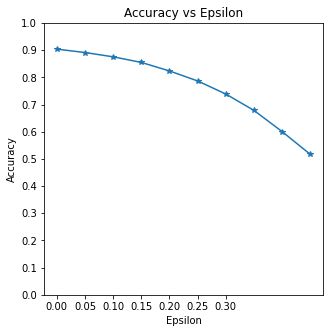

In [20]:
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Protect Model against FGSM

In [26]:
robust_net = Net().to(device)
protect_epochs = 10
protect_lr = 0.01
protect_bz = 32
protect_dec_lr = False

In [27]:
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
mini_opt = MiniBatchOptimizer(robust_net.parameters(), lr=protect_lr, decreasing_lr=protect_dec_lr)

In [14]:
#(model: Module, optim: Optimizer,criterion: Module, train_loader: Iterable, test_loader: Iterable, device, epochs: int = 10):
robust_net = protect(robust_net, mini_opt, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

NameError: name 'protect' is not defined

In [28]:
robust_net

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [31]:
for epoch in range(protect_epochs):
        # Train an epoch
        #robust_net.train()
        for batch_id, (batch_x, batch_y)in enumerate(prot_train_loader, 1):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass for adversarial perturbations
            batch_x.requires_grad = True
            output = robust_net(batch_x)

            original_predictions = output.argmax(1) # get the index of the max logit
            original_accuracy = accuracy(output, batch_y)
            loss = criterion(output, batch_y)
            robust_net.zero_grad()
            loss.backward()
            perturbed_data = fgsm(batch_x, batch_x.grad, 0.25)
            
            # Evaluate the network (forward pass)
            prediction = robust_net(perturbed_data)
            loss = criterion(prediction, batch_y)
            
            # Compute the gradient
            mini_opt.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            mini_opt.step()

        # Test the quality on the test set
        robust_net.eval()
        accuracies = []
        for batch_x, batch_y in prot_test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = robust_net(batch_x)
            accuracies.append(accuracy(prediction, batch_y))
        
        print("Epoch {:.2f} | Test accuracy: {:.5f}".format(epoch, sum(accuracies).item()/len(accuracies)))    

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [20, 1, 5, 5], but got 7-dimensional input of size [32, 1, 1, 1, 1, 28, 28] instead

In [ ]:
# Attack against Protected Model

In [ ]:
accuracies_lenet_robust = []
examples_lenet_robust = []

epsilons_lenet_robust = np.arange(0, 0.5, 0.05)

In [ ]:
for eps in epsilons_lenet_robust:
    acc, ex = attack(protected_net, CrossEntropyLoss(), prot_train_loader, eps, device=device)
    accuracies_lenet_robust.append(acc)
    examples_lenet_robust.append(ex)

In [ ]:
# Comparing the models
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-", c='blue', label='Convolutional network')
plt.plot(epsilons_lenet_robust, accuracies_lenet_robust, "*-", c='orange', label='Convolutional network (robust)')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();